In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(scores, y, net):
    acc = 0.0
    idxs = np.argmax(scores, axis=1)
    y_true = np.argmax(y, axis=1)
    acc = np.sum(idxs == y_true)
    return acc / y.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test_fin = test_data['data']

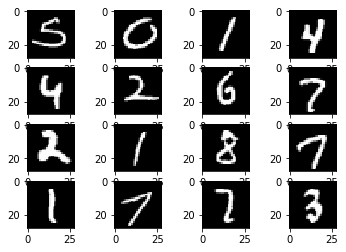

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

# Подготовка датасета

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.2, 
                                                    random_state=12, stratify=Y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=12)

In [8]:
mu = np.mean(X_train)
std = np.std(X_train)
eps = 1e-5

In [9]:
X_train = (X_train - mu) / (std + eps)
X_val = (X_val - mu) / (std + eps)
X_test = (X_test - mu) / (std + eps)
X_test_fin = (X_test_fin - mu) / (std + eps)

# Определение слоев сети

### affine_forward

In [10]:
def affine_forward(x, w, b):
    out = np.dot(x, w) + b
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    x, w, b = cache
    db = np.sum(dout, axis=0)
    dw = np.dot(x.T, dout)
    dx = np.dot(dout, w.T)
    return dx, dw, db

In [11]:
x = np.array([[1, 2, 3], [4, 5, 6]])
w = np.array([[1, 1], [1, 1], [1, 1]])
b = np.array([0.5, 0.4])
out, cachce = affine_forward(x, w, b)
dout = np.array([[1, 3], [1, 2]])
dx, dw, db = affine_backward(dout, cachce)

In [12]:
def relu_forward(x):
    out = np.maximum(0, x)
    cache = x
    return out, cache

def relu_backward(dout, cache):
    x = cache
    mask, _ = relu_forward(x)
    mask = mask > 0
    dout = dout * mask
    return dout

In [13]:
def dropout_forward():
    pass

In [14]:
def batchnorm_forward():
    pass

In [15]:
def cross_entropy(x, y):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    idxs = np.argmax(y, axis=1)
    loss = -np.sum(log_probs[np.arange(N), idxs]) / N
    dx = probs.copy()
    dx[np.arange(N), idxs] -= 1
    dx /= N
    return loss, dx

# Neuro Net

In [49]:
class MultiClassNet():
    
    def __init__(self, in_size, hidden_sizes, out_size, learning_rate=1e-4):
        self.lr = learning_rate
        self.W = []
        self.b = []
        sizes = np.hstack((in_size, hidden_sizes, out_size))
        for i in range(len(sizes) - 1):
            in_size = sizes[i]
            out_size = sizes[i+1]
            w = np.random.normal(scale=1, size=[in_size, out_size]) * np.sqrt(2 / in_size)
            b = np.zeros(out_size)
            self.W.append(w)
            self.b.append(b)
       
    def forward(self, batch):
        cache_aff = []
        cache_relu = []
        
        for n in range(len(self.W) - 1):
            batch, cur_aff_cache = affine_forward(batch, self.W[n], self.b[n])
            batch, cur_relu_cache = relu_forward(batch)
            cache_aff.append(cur_aff_cache)
            cache_relu.append(cur_relu_cache)
       
        n += 1
        batch, cur_aff_cache = affine_forward(batch, self.W[n], self.b[n])
        cache_aff.append(cur_aff_cache)
        return batch, (cache_aff, cache_relu)
    
    
    def backward(self, dout, cache):
        lr = self.lr
        cache_aff, cache_relu = cache
        
        dout, dw, db = affine_backward(dout, cache_aff[-1])
        self.W[-1] = self.W[-1] - lr * dw
        self.b[-1] = self.b[-1] - lr * db
        
        for i in range(len(self.W) - 2, -1, -1):
            dout = relu_backward(dout, cache_relu[i])
            dout, dw, db = affine_backward(dout, cache_aff[i])
            self.W[i] = self.W[i] - lr * dw
            self.b[i] = self.b[i] - lr * db
        
    def predict(self, x):
        scores, _ = self.forward(x)
        return scores 
    
    def train(self, x, y, batch_size=1, epoches=10):
        iter_per_ep = x.shape[0] // batch_size
        losses = []
        accs = []
        for ep in range(epoches):
            if(ep % 1 == 0):
                print('epoch:', ep)
            for i in range(iter_per_ep):
                print('iter:', i)
                """idx = np.random.randint(low=0, high=x.shape[0], size=batch_size)
                batch = x[idx]
                batch_y = y[idx]"""
                batch = copy.deepcopy(x)
                batch_y = y
                scores, cache = self.forward(batch)

                loss, dout = cross_entropy(scores, batch_y)
                losses.append(loss)
                acc = compute_acc(scores, batch_y, self)
                accs.append(acc)
                
                self.backward(dout, cache)
        return (losses, accs)

In [50]:
print(X_train.shape)

(33600, 784)


In [ ]:
net = MultiClassNet(X_train.shape[1], 500, 10, learning_rate=5e-5)
losses = net.train(X_train, y_train, batch_size = 5000, epoches=100)

epoch: 0
iter: 0


In [29]:
loss, accs = losses

In [30]:
scores = net.predict(X_train)

In [31]:
compute_acc(scores, y_train, net)

0.62875

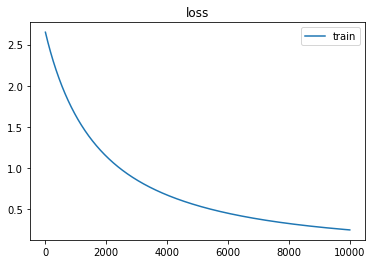

In [32]:
plt.title('loss')
plt.plot(loss, label='train')
plt.legend()

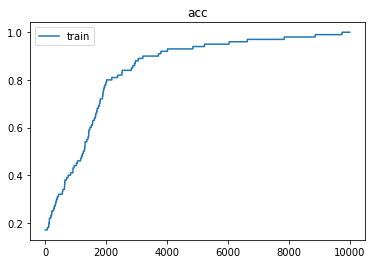

In [33]:
plt.title('acc')
plt.plot(accs, label='train')
plt.legend()

In [ ]:
# Здесь процедура обучения
# net = MnistNet()
# loss = CrossEntropy()
#...

In [ ]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
# plot(L_train, label="train")
# ...

In [ ]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_norm, net)